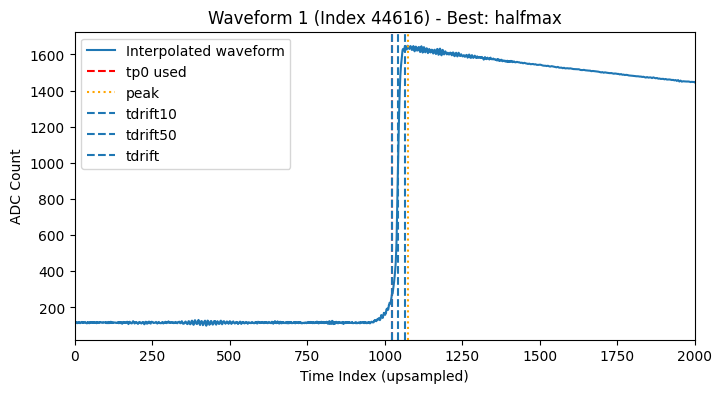

{'tdrift10': np.int64(0), 'tdrift50': np.int64(19), 'tdrift': np.int64(43)}


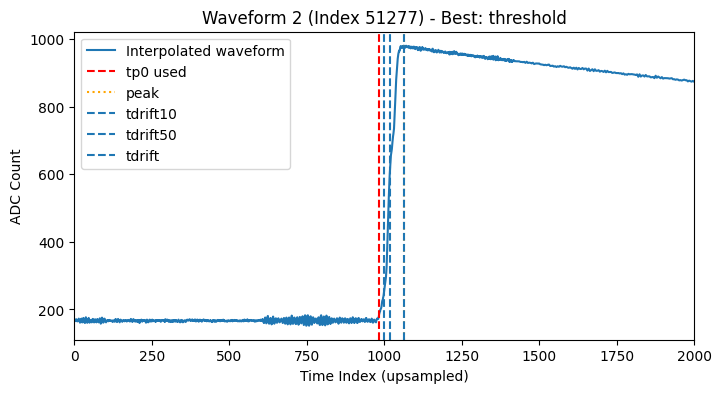

{'tdrift10': np.int64(16), 'tdrift50': np.int64(34), 'tdrift': np.int64(79)}


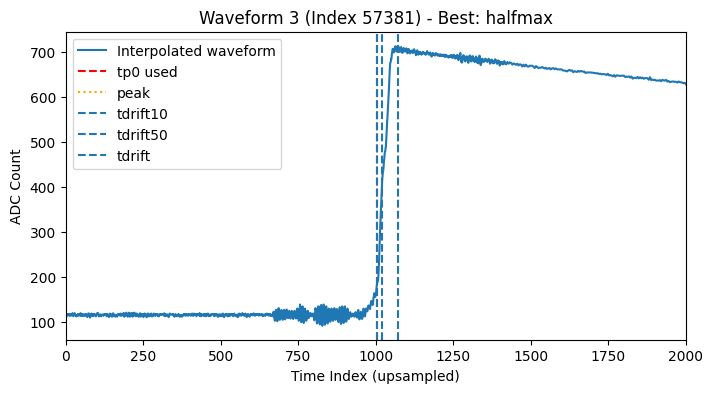

{'tdrift10': np.int64(0), 'tdrift50': np.int64(19), 'tdrift': np.int64(69)}
   Waveform  Index  tp0_truth  tp0_threshold  tp0_slope  tp0_halfmax  \
0         1  44616        949            388        823         1024   
1         2  51277        955            983       1008          999   
2         3  57381        953            678        676         1003   

   tp0_used Best_Method  Error_Best  tdrift10  tdrift50  tdrift  
0      1024     halfmax          75         0        19      43  
1       983   threshold          28        16        34      79  
2      1003     halfmax          50         0        19      69  


In [73]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def baseline_estimate(y, n_points=200):
    return np.mean(y[:n_points])

def tp0_threshold(y, k_sigma=5.0, n_points=200):
    baseline = baseline_estimate(y, n_points)
    noise_rms = np.std(y[:n_points] - baseline)
    threshold = baseline + k_sigma * noise_rms
    tp0_idx = np.argmax(y > threshold)
    return tp0_idx

def tp0_slope(y, window=5, slope_sigma=5.0, n_points=200):
    baseline = baseline_estimate(y, n_points)
    dy = np.diff(y, prepend=y[0])
    noise_rms = np.std(dy[:n_points])
    threshold = slope_sigma * noise_rms
    candidates = np.where((dy > threshold) & (y > baseline))[0]
    return candidates[0] if len(candidates) else np.argmax(y)

def tp0_halfmax(y, frac=0.1, n_points=200):
    baseline = baseline_estimate(y, n_points)
    peak_idx = np.argmax(y)
    peak_val = y[peak_idx]
    target = baseline + frac * (peak_val - baseline)
    idxs = np.where(y[:peak_idx] >= target)[0]
    return idxs[0] if len(idxs) else np.argmax(y)

def compute_drift_times(y, tp0_idx):
    baseline = np.mean(y[:200])
    peak_idx = np.argmax(y)
    peak_val = y[peak_idx]
    targets = {
        "tdrift10": baseline + 0.10 * (peak_val - baseline),
        "tdrift50": baseline + 0.50 * (peak_val - baseline),
        "tdrift": baseline + 0.999 * (peak_val - baseline),
    }
    drift_times = {}
    for label, target in targets.items():
        seg = y[tp0_idx:peak_idx + 10]  
        idxs = np.where(seg >= target)[0]
        drift_times[label] = idxs[0] if len(idxs) > 0 else np.nan
    return drift_times, peak_idx

file_path = "MJD_Test_0.hdf5"

with h5py.File(file_path, "r") as file:
    raw_waveform = np.array(file["raw_waveform"])
    tp0_truth = np.array(file["tp0"])
    energy_label = np.array(file["energy_label"])

random_indices = np.random.choice(raw_waveform.shape[0], 3, replace=False)

results = []

for i, idx in enumerate(random_indices):
    wf = raw_waveform[idx]
    tp0_true = tp0_truth[idx]
    energy = energy_label[idx]
    
    tp0_1 = tp0_threshold(wf)
    tp0_2 = tp0_slope(wf)
    tp0_3 = tp0_halfmax(wf)
    
    errors = {
        "threshold": abs(tp0_1 - tp0_true),
        "slope": abs(tp0_2 - tp0_true),
        "halfmax": abs(tp0_3 - tp0_true)
    }
    best_method = min(errors, key=errors.get)
    tp0_used = {"threshold": tp0_1, "slope": tp0_2, "halfmax": tp0_3}[best_method]
    
    x_old = np.arange(len(wf))
    f = interp1d(x_old, wf, kind="linear")
    x_new = np.linspace(0, len(wf)-1, len(wf))
    y_new = f(x_new)
    
    drift_times, peak_idx = compute_drift_times(y_new, tp0_used )
    
    results.append({
        "Waveform": i + 1,
        "Index": idx,
        "Energy": energy,
        "tp0_truth": tp0_true,
        "tp0_threshold": tp0_1,
        "tp0_slope": tp0_2,
        "tp0_halfmax": tp0_3,
        "tp0_used": tp0_used,
        "Best_Method": best_method,
        "Error_Best": errors[best_method],
        **drift_times
    })
    
    plt.figure(figsize=(8,4))
    plt.xlim(0, 2000)
    plt.plot(x_new, y_new, label="Interpolated waveform")
    plt.axvline(tp0_used, color='r', ls='--', label='tp0 used')
    plt.axvline(peak_idx, color='orange', ls=':', label='peak')
    for label, val in drift_times.items():
        if not np.isnan(val):
            plt.axvline(tp0_used + val, ls='--', label=label)
    plt.title(f"Waveform {i+1} (Index {idx}) - Best: {best_method}")
    plt.xlabel("Time Index (upsampled)")
    plt.ylabel("ADC Count")
    plt.legend()
    plt.show()

    print(drift_times)


import pandas as pd
df = pd.DataFrame(results)
print(df[["Waveform","Index","tp0_truth","tp0_threshold","tp0_slope",
          "tp0_halfmax","tp0_used","Best_Method","Error_Best",
          "tdrift10","tdrift50","tdrift"]])


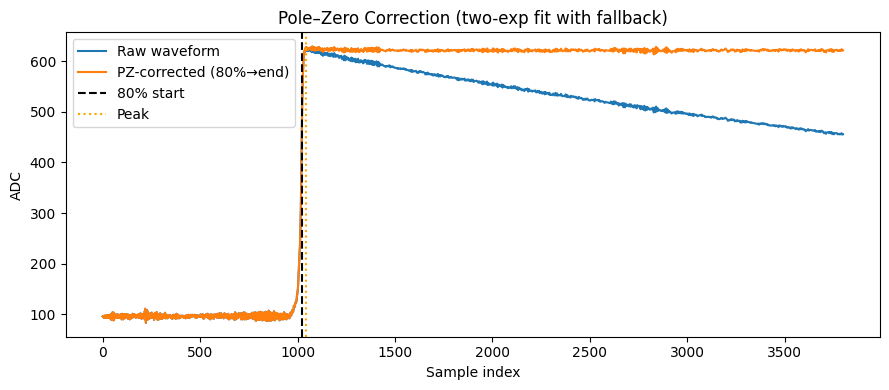

Two-exp tail fit: alpha=457, tau1=6.17e+03, beta=164, tau2=1e+06


In [74]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

file_path = "MJD_Test_0.hdf5"

with h5py.File(file_path, "r") as f:
    raw_waveform = np.array(f["raw_waveform"])  
    tp0 = np.array(f["tp0"])

idx = np.random.randint(0, raw_waveform.shape[1])   
wf = raw_waveform[idx].astype(float)
tp0_idx = int(tp0_used)

baseline = np.mean(wf[:200])
peak_i = int(np.argmax(wf))
peak_v = wf[peak_i]
t80_level = baseline + 0.80*(peak_v - baseline)

seg = wf[tp0_idx:peak_i+1]
idxs = np.where(seg >= t80_level)[0]
if len(idxs) == 0:
    raise RuntimeError("80% level not reached after tp0; check tp0 or use 70% instead.")
i80 = tp0_idx + int(idxs[0])               
t = np.arange(len(wf), dtype=float)
t_tail = t[i80:]                             
y_tail = wf[i80:]                            

def two_exp(tt, alpha, tau1, beta, tau2):
    x = (tt - t_tail[0])
    return alpha*np.exp(-x/np.maximum(tau1, 1e-9)) + beta*np.exp(-x/np.maximum(tau2, 1e-9))

def one_exp(tt, A, tau, C):
    x = (tt - t_tail[0])
    return A*np.exp(-x/np.maximum(tau, 1e-9)) + C

A0 = max(y_tail) - min(y_tail)
p0_two = [0.7*A0, 300.0, 0.3*A0, 3000.0] 
bounds_two = ([0.0, 1.0, 0.0,   10.0],     
              [10*A0, 1e6, 10*A0, 1e6])

use_two_exp = True
try:
    popt_two, _ = curve_fit(two_exp, t_tail, y_tail, p0=p0_two, bounds=bounds_two, maxfev=20000)
    fit_tail = two_exp(t_tail, *popt_two)
except Exception:
    use_two_exp = False
    p0_one = [A0, 1500.0, np.median(y_tail)]
    bounds_one = ([0.0, 1.0, min(y_tail)-abs(A0)],
                  [10*A0, 1e6, max(y_tail)+abs(A0)])
    popt_one, _ = curve_fit(one_exp, t_tail, y_tail, p0=p0_one, bounds=bounds_one, maxfev=20000)
    fit_tail = one_exp(t_tail, *popt_one)

eps = 1e-12
f_decay = np.maximum(fit_tail, eps)
f_pz = 1.0 / f_decay
f_pz /= f_pz[0]  

wf_pz = wf.copy()
wf_pz[i80:] = wf[i80:] * f_pz

plt.figure(figsize=(9,4))
plt.plot(t, wf, label="Raw waveform")
plt.plot(t, wf_pz, label="PZ-corrected (80%→end)")
plt.axvline(i80, color='k', ls='--', label="80% start")
plt.axvline(peak_i, color='orange', ls=':', label="Peak")
plt.title("Pole–Zero Correction (two-exp fit with fallback)")
plt.xlabel("Sample index")
plt.ylabel("ADC")
plt.legend()
plt.tight_layout()
plt.show()

if use_two_exp:
    alpha, tau1, beta, tau2 = popt_two
    print(f"Two-exp tail fit: alpha={alpha:.3g}, tau1={tau1:.3g}, beta={beta:.3g}, tau2={tau2:.3g}")
else:
    A, tau, C = popt_one
    print(f"One-exp tail fit (fallback): A={A:.3g}, tau={tau:.3g}, C={C:.3g}")
